In [25]:
from scipy import stats
from scipy.stats import norm
from statsmodels.distributions.empirical_distribution import ECDF
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import json

In [26]:
files = glob.glob("dados/*.json")

- Número total de Tweets

In [52]:
size = 0
for each in files:
    with open(each, 'r', encoding="utf8") as f:
        data = json.load(f)
        size += len(data)
size

48413

- Distribuição do tamanho das florestas. Cada Tweet gera uma floresta.
Gerar o gráfico da CDF dos tamanhos das florestas de cada Tweet;

In [28]:
size_forests = dict()
for filename in files:
    fa = filename.split("_")
    fa = fa[1].split(".")
    with open(filename, 'r', encoding="utf8") as f:
        try:
            size_forests[fa[0]] += len(json.load(f))
        except:
            size_forests[fa[0]] = len(json.load(f))

In [29]:
np_forests = np.array(tuple(size_forests.values()))

In [30]:
ecdf = ECDF(np_forests)

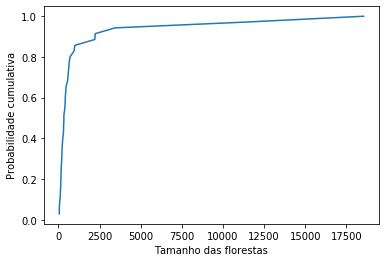

In [57]:
_= plt.plot(ecdf.x, ecdf.y)
_= plt.xlabel("Tamanho das florestas")
_= plt.ylabel("Probabilidade cumulativa")

- Para cada árvore principal (respostas e replies diretas ao Tweet),
gerar a distribuição do tamanho, altura e "largura" (pensar em formas
de descrever as árvores com números.)

- Para cada árvore secundária (arvores das citações) fazer o mesmo do
item acima.

- Para cada interação com um tweet, calcular o tempo entre a interação
e o pai imediatamente acima (resposta e tweet respondido). Fazer uma
distribuição desses valores de tempos de resposta.

In [32]:
#se aumentar a base de dados, rodar o arquivo  response_time.py antes
arr = []
for filename in files:
    with open(filename, 'r', encoding="utf8") as f:    
        data = json.load(f)
        for item in data:
            arr.append(data[item]['response_time'])     

In [33]:
np_responses = np.array(arr)

In [34]:
ecdf_responses = ECDF(np_responses)

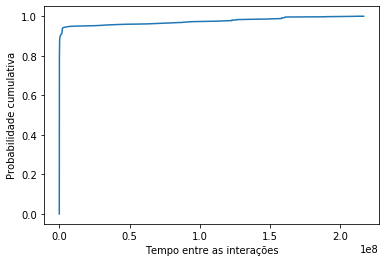

In [59]:
_= plt.plot(ecdf_responses.x, ecdf_responses.y)
_= plt.xlabel("Tempo entre as interações")
_= plt.ylabel("Probabilidade cumulativa")

- Número de usuários diferentes em cada árvore (fazer para a árvore
principal e para as secundárias).

In [39]:
main_users = dict()
sec_users = dict()
for filename in files:
    fa = filename.split("_")
    different_users = dict()
    with open(filename, 'r', encoding="utf8") as f:   
        data = json.load(f)
        for item in data:
            try:
                different_users[data[item]['user_id']] += 1
            except:
                different_users[data[item]['user_id']] = 1
            if(len(fa) == 2):
                main_users[filename] = len(different_users)
            else:
                sec_users[filename] = len(different_users)        

In [43]:
np_musers = np.array(tuple(main_users.values()))
np_susers = np.array(tuple(sec_users.values()))

In [45]:
ecdf_musers = ECDF(np_musers)
ecdf_susers = ECDF(np_susers)

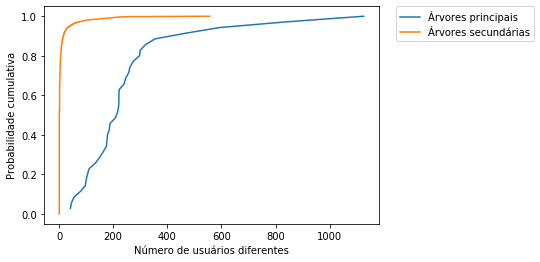

In [58]:
_= plt.plot(ecdf_musers.x, ecdf_musers.y, label="Árvores principais")
_= plt.plot(ecdf_susers.x, ecdf_susers.y, label="Árvores secundárias")
_= plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
_= plt.xlabel("Número de usuários diferentes")
_= plt.ylabel("Probabilidade cumulativa")